In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "image", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok = True)

def save_fig(fig_id, tight_layout = True, fig_extension='png', resolution = 300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장 : ", fig_id)
    if tight_layout :
        plt.tight_layout()
    plt.savefig(path, format=fig_extenstion, dpi=resolution)

## 13.1 데이터 API

### 13.1.1 연쇄 변환

In [2]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [3]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [4]:
print(X)

tf.Tensor([0 1 2 3 4 5 6 7 8 9], shape=(10,), dtype=int32)


In [5]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [6]:
dataset = dataset.map(lambda x: x*2)

In [7]:
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [8]:
dataset = dataset.unbatch()
dataset = dataset.filter(lambda x: x < 10)

In [9]:
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


In [10]:
tf.random.set_seed(42)

dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size = 3, seed = 42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([1 3 0 4 2 5 6], shape=(7,), dtype=int64)
tf.Tensor([8 7 1 0 3 2 5], shape=(7,), dtype=int64)
tf.Tensor([4 6 9 8 9 7 0], shape=(7,), dtype=int64)
tf.Tensor([3 1 4 5 2 8 7], shape=(7,), dtype=int64)
tf.Tensor([6 9], shape=(2,), dtype=int64)


### 13.1.2 데이터 셔플링

In [11]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [12]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

In [13]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")
    
    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding = "utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
            return filepaths

In [14]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ','.join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=20)

In [15]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


In [16]:
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end = '')

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


In [17]:
train_filepaths

['datasets\\housing\\my_train_00.csv']

In [18]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [19]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)


In [20]:
n_readers = 5
dataset = filepath_dataset.interleave(
lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length = n_readers)

Cause: could not parse the source code:

lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length = n_readers)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length = n_readers)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [21]:
for line in dataset.take(5):
    print(line.numpy())

b'3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442'
b'5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687'
b'3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621'
b'7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621'
b'2.0549,13.0,5.312457454050374,1.0850918992511913,3297.0,2.2443839346494214,33.93,-116.93,0.956'


In [22]:
record_defaults = [0, np.nan, tf.constant(np.nan, dtype=tf.float64), "Hello", tf.constant([])]
parsed_fields = tf.io.decode_csv('1,2,3,4,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.0>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'4'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

In [23]:
parsed_fields  = tf.io.decode_csv(',,,,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'Hello'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

In [24]:
try :
    parsed_fields = tf.io.decode_csv(",,,,", record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Field 4 is required but missing in record 0! [Op:DecodeCSV]


In [25]:
try:
    parsed_fields = tf.io.decode_csv('1,2,3,4,5,6,7', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Expect 5 fields but have 7 in record 0 [Op:DecodeCSV]


In [26]:
n_inputs = 8

@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [27]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

In [28]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5, n_read_threads=None,
                      shuffle_buffer_size=10000, n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls = n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [29]:
tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print("X=", X_batch)
    print("y=", y_batch)
    print()

X= tf.Tensor(
[[-0.44622147  0.5834586  -0.7286469  -0.08566543 -0.32514533  0.54887956
  -0.78068835  0.70185536]
 [-0.9555775   0.6625668  -0.5383187   0.02105281 -0.25396186  0.5783319
  -1.3850268   1.2316071 ]
 [ 0.5523785  -1.3151377   0.26649237 -0.22619449 -0.3753388  -0.04119827
   0.3061831   0.12712272]], shape=(3, 8), dtype=float32)
y= tf.Tensor(
[[1.654]
 [0.885]
 [1.156]], shape=(3, 1), dtype=float32)

X= tf.Tensor(
[[-1.1641386   1.8491895  -0.4503311  -0.1760986  -0.5268318   0.01442639
   1.2431414  -1.3521868 ]
 [ 0.5687722   0.42524222  0.3732612  -0.19992226 -0.4264449   0.08010553
  -0.8415911   0.7968123 ]
 [ 1.2545304   0.42524222  0.31844658 -0.09886024 -0.35891184 -0.08249054
  -0.88843834  0.6368871 ]], shape=(3, 8), dtype=float32)
y= tf.Tensor(
[[1.833]
 [2.126]
 [3.964]], shape=(3, 1), dtype=float32)



### 13.1.6. tf.keras와 데이터셋 사용하기

In [30]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [31]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape = X_train.shape[1:]),
    keras.layers.Dense(1)
])

In [32]:
model.compile(loss = "mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [33]:
batch_size = 32
model.fit(train_set, steps_per_epoch = len(X_train)//batch_size, epochs=10, validation_data = valid_set)

Epoch 1/10
362/362 [==============================] - 1s 2ms/step - loss: 1.3680 - val_loss: 30.2033
Epoch 2/10
362/362 [==============================] - 1s 1ms/step - loss: 0.6864 - val_loss: 23.4493
Epoch 3/10
362/362 [==============================] - 0s 1ms/step - loss: 0.5774 - val_loss: 17.5785
Epoch 4/10
362/362 [==============================] - 0s 1ms/step - loss: 0.5491 - val_loss: 13.2287
Epoch 5/10
362/362 [==============================] - 0s 1ms/step - loss: 0.5027 - val_loss: 10.2133
Epoch 6/10
362/362 [==============================] - 1s 2ms/step - loss: 0.4982 - val_loss: 7.6881
Epoch 7/10
362/362 [==============================] - 1s 2ms/step - loss: 0.4787 - val_loss: 5.6783
Epoch 8/10
362/362 [==============================] - 1s 2ms/step - loss: 0.4822 - val_loss: 4.1760
Epoch 9/10
362/362 [==============================] - 1s 2ms/step - loss: 0.4428 - val_loss: 3.0772
Epoch 10/10
362/362 [==============================] - 1s 1ms/step - loss: 0.4381 - val_loss: 2

In [34]:
model.evaluate(test_set, steps=len(X_test) // batch_size)

  9/161 [>.............................] - 0s 11ms/step - loss: 0.4984


0.49843698740005493

In [35]:
new_set = test_set.map(lambda X, y : X)
X_new = X_test
model.predict(new_set, steps = len(X_new)//batch_size)

array([[1.5684748 ],
       [2.0137548 ],
       [1.6615092 ],
       [1.5782373 ],
       [0.4144505 ],
       [1.5003132 ],
       [3.948031  ],
       [1.3245556 ],
       [1.824839  ],
       [2.9856575 ],
       [2.958857  ],
       [1.5271338 ],
       [1.6157024 ],
       [1.1803076 ],
       [2.0561411 ],
       [1.1790056 ],
       [1.8350049 ],
       [2.3608685 ],
       [5.230833  ],
       [3.489607  ],
       [1.2586374 ],
       [2.1081197 ],
       [0.49183756],
       [3.1267161 ],
       [2.599792  ],
       [1.5189158 ],
       [2.8568854 ],
       [3.023068  ],
       [1.420066  ],
       [2.5535703 ],
       [1.9469614 ],
       [2.9522078 ],
       [2.5840201 ],
       [2.9488611 ],
       [2.759444  ],
       [2.4454303 ],
       [1.6989417 ],
       [1.8947052 ],
       [2.110322  ],
       [2.515546  ],
       [1.4858513 ],
       [2.405543  ],
       [0.95574087],
       [3.0524223 ],
       [4.3167195 ],
       [1.7388008 ],
       [3.0283582 ],
       [1.831

In [36]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 5
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0
for X_batch, y_batch in train_set.take(total_steps):
    global_step += 1
    print("\rGlobal step {}/{}".format(global_step, total_steps), end="")
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 1810/1810

In [37]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [38]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

In [39]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [40]:
optimizer = keras.optimizers.Nadam(lr = 0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_eopchs, batch_size=32, n_readers=5, n_read_threads=5, shuffle_buffer_size = 10000, n_parsed_threads = 5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers = n_readers, n_read_threads = n_read_threads, shuffle_buffer_size = shuffle_buffer_size, n_parse_threads = n_parsed_threads, batch_size = batch_size)
    n_steps_per_epoch = len(X_train) // batch_size
    total_size = n_epochs * n_steps_per_epoch
    global_step = 0
    for X_batch, y_batch in train_set.take(total_steps):
        global_step += 1
        if tf.equal(global_step % 100, 0):
            tf.print("\rGlobal step", global_step, "/", total_steps)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

In [41]:
for m in dir(tf.data.Dataset):
    if not(m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("*{:21s}{}".format(m+"()", func.__doc__.split("\n")[0]))

*apply()              Applies a transformation function to this dataset.
*as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
*batch()              Combines consecutive elements of this dataset into batches.
*cache()              Caches the elements in this dataset.
*cardinality()        Returns the cardinality of the dataset, if known.
*concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
*element_spec()       The type specification of an element of this dataset.
*enumerate()          Enumerates the elements of this dataset.
*filter()             Filters this dataset according to `predicate`.
*flat_map()           Maps `map_func` across this dataset and flattens the result.
*from_generator()     Creates a `Dataset` whose elements are generated by `generator`.
*from_tensor_slices() Creates a `Dataset` whose elements are slices of the given tensors.
*from_tensors()       Creates a `Dataset` with a single

## 13.2 TFRecord 포맷

### 13.2.2 프로토콜 버퍼 개요

In [42]:
%%writefile person.proto
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}

Overwriting person.proto


In [43]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

'protoc'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [44]:
!ls person*

'ls'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [45]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }))

with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

In [46]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)

In [47]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x2417e062208>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [48]:
parsed_example["emails"].values[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'a@b.com'>

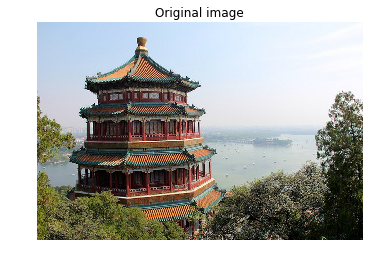

In [49]:
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original image")
plt.show()

In [50]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features=Features(feature={"image":Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()

In [51]:
feature_description = {"image" : tf.io.VarLenFeature(tf.string)}
example_with_image = tf.io.parse_single_example(serialized_example, feature_description)
decode_img = tf.io.decode_jpeg(example_with_image["image"].values[0])

In [52]:
decode_img = tf.io.decode_image(example_with_image["image"].values[0])

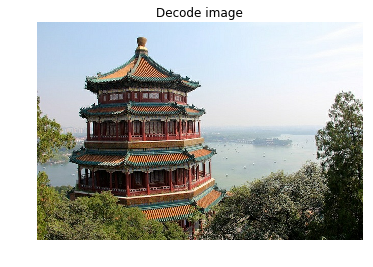

In [53]:
plt.imshow(decode_img)
plt.title("Decode image")
plt.axis("off")
plt.show()